In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_cleaned.csv to test_cleaned.csv
Saving train_cleaned.csv to train_cleaned.csv


In [ ]:
!pip install transformers

In [ ]:
import transformers
import os
import gc
import pandas as pd
import numpy as np
import pickle
import random
import re
import time
import warnings
import string

import tensorflow_hub as hub
from tqdm.notebook import tqdm
import tensorflow as tf
from keras import backend as K
import tensorflow.keras.layers as layers
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Dense, Input, Conv1D, GlobalMaxPooling1D, Dropout, BatchNormalization, Average
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVC
from transformers import logging
logging.set_verbosity_error()
pd.set_option('max_colwidth', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)


tf.random.set_seed(42)
random.seed(42)

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

In [ ]:
import io
df_test= pd.read_csv(io.BytesIO(uploaded['test_cleaned.csv']))
df_train= pd.read_csv(io.BytesIO(uploaded['train_cleaned.csv']))

In [ ]:
train=df_train.copy()
test=df_test.copy()

In [ ]:
# Thêm keyword vào text_cleaned
def concatKeyWord(df):
    df['text_cleaned'] = df.apply(lambda row: ' '.join([row['keyword_cleaned'], row['text_cleaned']])
                                  if row['keyword_cleaned'] != "no_keyword" else row['text_cleaned'], axis=1)
    return df

In [ ]:
train=concatKeyWord(train)
test=concatKeyWord(test)
train.sample(5, random_state=11)["text_cleaned"]

6224                                                                              tsunami senior year want go
1439            cliff fall est villa black died stroke fall spain sir cliff revealed due visit spain next url
5558                                                                           smoke tweetermention try smoke
4595    natural disaster patriot survival guide know survive government collapse natural disaster happens url
3740       hailstorm well much outdoor fostering tweetermention mother nature hailstorm rain fringe kill hard
Name: text_cleaned, dtype: object

In [ ]:
new_train=train[['text_cleaned', 'target']]
new_test=test[['text_cleaned']]

In [ ]:
from transformers import BertTokenizer

# Khởi tạo tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

def bert_encode(data, max_len):
    """
    Hàm này thực hiện mã hóa văn bản sử dụng tokenizer BERT.

    Tham số:
    - data: DataFrame - DataFrame chứa cột 'text_cleaned' chứa văn bản cần mã hóa.
    - max_len: int - Độ dài tối đa cho chuỗi đầu ra.

    Trả về:
    - input_ids: numpy array - Mảng numpy chứa mã hóa các đầu vào.
    - attention_masks: numpy array - Mảng numpy chứa attention mask tương ứng với mã hóa các đầu vào.
    """

    input_ids = []
    attention_masks = []

    for i in range(len(data.text_cleaned)):
        # Mã hóa văn bản với tokenizer BERT
        encoded = tokenizer.encode_plus(data.text_cleaned[i], add_special_tokens=True, max_length=max_len, pad_to_max_length=True)

        tok_len = sum(encoded['attention_mask'])

        if tok_len > max_len * 0.8:
            # Nếu độ dài mã hóa vượt quá 80% độ dài tối đa cho phép
            # Thực hiện mã hóa lại với độ dài bằng một nửa độ dài tối đa
            all_encode = tokenizer.encode_plus(data.text_cleaned[i], add_special_tokens=True)
            all_ids = all_encode['input_ids']
            all_attention = all_encode['attention_mask']
            max_len_half = int(max_len / 2)
            input_ids.append(all_ids[:max_len_half] + all_ids[-max_len_half:])
            attention_masks.append(all_attention[:max_len_half] + all_attention[-max_len_half:])
        else:
            # Nếu độ dài mã hóa không vượt quá 80% độ dài tối đa cho phép
            # Sử dụng mã hóa và attention mask hiện tại
            input_ids.append(encoded['input_ids'])
            attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)


# Mã hóa dữ liệu huấn luyện và kiểm tra
train_input_ids, train_attention_masks = bert_encode(new_train, 50)
test_input_ids, test_attention_masks = bert_encode(new_test, 50)

# Chuẩn bị nhãn huấn luyện
y_train = train.target

In [ ]:
print(train_input_ids.shape,y_train.shape)
# print(test_input_ids.shape,y_test.shape)

(6827, 50) (6827,)


In [ ]:
N_SAMPLES = 8

def create_model(bert_model, MAX_LEN=50):
    """
    Hàm tạo mô hình BERT với đầu vào là một pretrained model BERT.

    Tham số:
    - bert_model: PretrainedModel - Mô hình BERT đã được huấn luyện.
    - MAX_LEN: int - Độ dài tối đa của chuỗi đầu vào.

    Trả về:
    - model: Model - Mô hình BERT đã được tạo.
    """
    # Định nghĩa đầu vào của mô hình
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')

    # Lấy đầu ra chuỗi từ pretrained model BERT
    sequence_output = bert_model(input_ids, attention_mask)[0]
    clf_output = sequence_output[:, 0, :]

    # Tính toán đầu ra của mô hình
    x_avg = layers.GlobalAveragePooling1D()(sequence_output)
    x_max = layers.GlobalMaxPooling1D()(sequence_output)
    clf_output = layers.Concatenate()([x_avg, x_max])

    # Tạo các mẫu đầu ra dự đoán
    samples = []
    for n in range(N_SAMPLES):
        sample_mask = layers.Dense(64, activation='relu', name=f'dense_{n}')
        sample = layers.Dropout(.5)(clf_output)
        sample = sample_mask(sample)
        sample = layers.Dense(1, activation='sigmoid', name=f'sample_{n}')(sample)
        samples.append(sample)

    # Tính toán đầu ra cuối cùng của mô hình
    output = layers.Average(name='output')(samples)

    # Tạo mô hình
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(Adam(learning_rate=1e-5), loss=BinaryCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

    return model

In [ ]:
from transformers import TFBertModel

# Tải mô hình BERT đã được huấn luyện trước
bert_model = TFBertModel.from_pretrained('bert-large-uncased')

# Tạo mô hình
model = create_model(bert_model)

# Hiển thị thông tin tóm tắt của mô hình
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 50,                                            

In [ ]:
def lgb_svc_cv(model):
    # Trích xuất các đặc trưng từ lớp trung gian của mô hình
    cls_layer_model = Model(model.input, outputs=model.get_layer(f'dense_1').output)
    X_train = cls_layer_model.predict([train_input_ids,train_attention_masks])
    X_test = cls_layer_model.predict([test_input_ids,test_attention_masks])
    y_train = train.target.values

    # Mô hình LGBM
    N_FOLDS = 5
    print(f'LGBM')
    folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
    oof = np.zeros(len(X_train))
    sub = np.zeros(len(X_test))
    params = {'boosting_type': 'dart'}
    for fold_, (train_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        # Chia dữ liệu huấn luyện thành tập huấn luyện và tập validation
        X_train_cv, y_train_cv = pd.DataFrame(X_train).loc[train_idx], pd.DataFrame(y_train).loc[train_idx]
        X_val, y_val = pd.DataFrame(X_train).loc[val_idx], pd.DataFrame(y_train).loc[val_idx]

        # Tạo các bộ dữ liệu LGBM
        train_data = lgb.Dataset(X_train_cv, label=y_train_cv)
        val_data = lgb.Dataset(X_val, label=y_val)
        watchlist = [train_data, val_data]

        # Huấn luyện mô hình LGBM
        clf = lgb.train(params, train_set=train_data, valid_sets=watchlist)

        # Dự đoán trên tập validation và tích lũy kết quả
        oof[val_idx] = clf.predict(X_val)

        # Dự đoán trên tập test và tích lũy kết quả để tính trung bình
        sub += clf.predict(X_test) / folds.n_splits

    sub_all_lgb = sub
    print(accuracy_score(y_train, np.round(oof).astype(int)),'\n')

    # Mô hình SVC
    print(f'SVC')
    folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
    oof = np.zeros(len(X_train))
    sub = np.zeros(len(X_test))
    scores = [0 for _ in range(folds.n_splits)]
    for fold_, (train_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        # Chia dữ liệu huấn luyện thành tập huấn luyện và tập validation
        X_train_cv, y_train_cv = pd.DataFrame(X_train).loc[train_idx], pd.DataFrame(y_train).loc[train_idx]
        X_val, y_val = pd.DataFrame(X_train).loc[val_idx], pd.DataFrame(y_train).loc[val_idx]

        # Huấn luyện mô hình SVC
        clf = SVC(kernel='rbf', C=1.75, gamma=0.1, probability=True).fit(X_train_cv, y_train_cv)

        # Dự đoán xác suất trên tập validation và tích lũy kết quả
        oof[val_idx] = clf.predict_proba(X_val)[:, 1]

        # Dự đoán xác suất trên tập test và tích lũy kết quả để tính trung bình
        sub += clf.predict_proba(X_test)[:, 1] / folds.n_splits

    sub_all_svc = sub
    print(accuracy_score(y_train, np.round(oof).astype(int)),'\n')

    # Trả về kết quả dự đoán từ mô hình LGBM và SVC
    return sub_all_lgb, sub_all_svc


In [ ]:
oof_preds = np.zeros(train_input_ids.shape[0])
test_preds = np.zeros(test.shape[0])
all_preds = pd.DataFrame()

fold_hist = {}
n_splits = 2
folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Vòng lặp chia dữ liệu thành các fold và huấn luyện mô hình trên từng fold
for i, (trn_idx, val_idx) in enumerate(folds.split(train_input_ids)):
    modelstart = time.time()

    # Tạo mô hình BERT và mô hình tổng thể
    bert_model = TFBertModel.from_pretrained('bert-large-uncased')
    model = create_model(bert_model)

    # Sử dụng EarlyStopping để dừng huấn luyện sớm nếu không có cải thiện đáng kể
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1,
                                 mode='min', baseline=None, restore_best_weights=True)

    # Định nghĩa hàm giảm learning rate theo epoch
    def lr_sc(epoch):
        return 1.5e-5/(epoch + 1)
    scheduler = LearningRateScheduler(lr_sc)

    # Huấn luyện mô hình trên fold hiện tại
    history = model.fit(
        x=[train_input_ids[trn_idx], train_attention_masks[trn_idx]], y=y_train[trn_idx],
        validation_data=([train_input_ids[val_idx], train_attention_masks[val_idx]], y_train[val_idx]),
        epochs=3,
        batch_size=16,
        callbacks=[scheduler, es]
    )

    # Lấy chỉ số của epoch có val_loss nhỏ nhất để lưu lại
    best_index = np.argmin(history.history['val_loss'])
    fold_hist[i] = history

    # Dự đoán trên tập validation và lưu lại kết quả vào oof_preds
    oof_preds[val_idx] = model.predict([train_input_ids[val_idx], train_attention_masks[val_idx]]).ravel()

    # Dự đoán trên tập test và lưu lại kết quả vào all_preds
    all_preds[str(i) + '_fold_NN'] = model.predict([test_input_ids,test_attention_masks]).reshape(-1)

    # Tính accuracy score trên tập validation
    sc = accuracy_score(y_train[val_idx], (oof_preds[val_idx] > 0.5).astype(int))
    print("\nFOLD {} in {:.1f} min - Avg Acc NN {:.5f} - Best Epoch {}".format(i, (time.time() - modelstart)/60, sc, best_index + 1),'\n')

    # Sử dụng LGBM và SVC trên fold hiện tại
    all_preds[str(i) + '_fold_lgb'], all_preds[str(i) + '_fold_svc'] = lgb_svc_cv(model)

    # Giải phóng bộ nhớ và xóa các biến
    del model
    K.clear_session()
    gc.collect()


Epoch 1/3
214/214 [==============================] - 291s 817ms/step - loss: 0.5900 - accuracy: 0.7170 - val_loss: 0.5189 - val_accuracy: 0.8026 - lr: 1.5000e-05
Epoch 2/3
214/214 [==============================] - 162s 756ms/step - loss: 0.5043 - accuracy: 0.8046 - val_loss: 0.5278 - val_accuracy: 0.7970 - lr: 7.5000e-06
Epoch 3/3
102/102 [==============================] - 35s 342ms/step

FOLD 0 in 11.8 min - Avg Acc NN 0.81459 - Best Epoch 3 

102/102 [==============================] - 35s 344ms/step
LGBM
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14634
[LightGBM] [Info] Number of data points in the train set: 5461, number of used features: 62
[LightGBM] [Info] Start training from score 0.406519
[1]	training's l2: 0.216191	valid_1's l2: 0.219994
[2]	training's l2: 0.195664	valid_1's l2: 0.203566
[3]	training's l2: 0.178649	valid_1's l2

Epoch 1/3
214/214 [==============================] - 279s 807ms/step - loss: 0.5471 - accuracy: 0.7645 - val_loss: 0.4946 - val_accuracy: 0.8131 - lr: 1.5000e-05
Epoch 2/3
214/214 [==============================] - 163s 762ms/step - loss: 0.4426 - accuracy: 0.8530 - val_loss: 0.4922 - val_accuracy: 0.8268 - lr: 7.5000e-06
Epoch 3/3
102/102 [==============================] - 35s 343ms/step

FOLD 1 in 11.8 min - Avg Acc NN 0.82186 - Best Epoch 2 

102/102 [==============================] - 35s 341ms/step
LGBM
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14043
[LightGBM] [Info] Number of data points in the train set: 5461, number of used features: 61
[LightGBM] [Info] Start training from score 0.406519
[1]	training's l2: 0.211324	valid_1's l2: 0.215114
[2]	training's l2: 0.186827

Tính toán kết quả dự đoán trên tập test bằng cách lấy trung bình có trọng số của các dự đoán từ mô hình neural network (NN), LGBM và SVC trên các fold. Cụ thể, nó tính trung bình có trọng số của các cột 0_fold_NN và 1_fold_NN từ all_preds nhân với trọng số 0.5, sau đó cộng với trung bình có trọng số của các cột 0_fold_lgb và 1_fold_lgb nhân với trọng số 0.25, và cuối cùng cộng với trung bình có trọng số của các cột 0_fold_svc và 1_fold_svc nhân với trọng số 0.25. Kết quả được lưu vào biến test_pred.

In [ ]:
test_pred = all_preds[['0_fold_NN','1_fold_NN']].mean(axis = 1)*.5 + all_preds[['0_fold_lgb','1_fold_lgb']].mean(axis = 1)*.25 + all_preds[['0_fold_svc','1_fold_svc']].mean(axis = 1)*.25

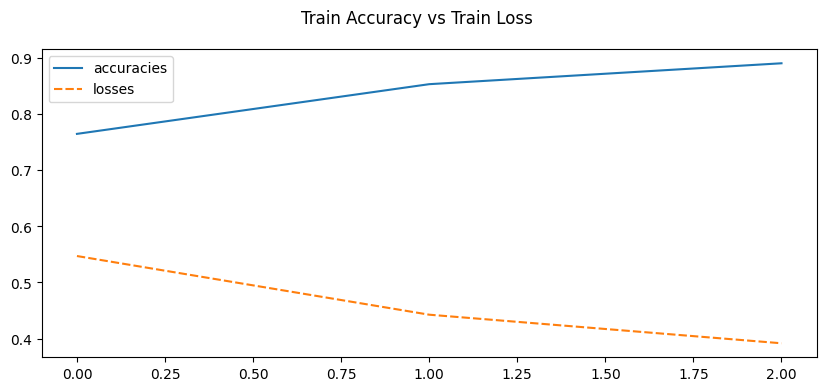

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot train accuracy and loss
accuracies = history.history['accuracy']
losses = history.history['loss']
accuracies_losses = list(zip(accuracies, losses))

accuracies_losses_df = pd.DataFrame(accuracies_losses, columns=["accuracies", "losses"])

plt.figure(figsize=(10, 4))
plt.suptitle("Train Accuracy vs Train Loss")
sns.lineplot(data=accuracies_losses_df)
plt.show()

In [ ]:
test_pred=np.round(test_pred).astype(int)

In [ ]:
from sklearn.metrics import classification_report
# Tạo classification report cho dữ liệu huấn luyện
train_report = classification_report(y_train, np.round(oof_preds).astype(int))
print("Classification Report - Training Data:")
print(train_report)

Classification Report - Training Data:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      4052
           1       0.80      0.73      0.77      2775

    accuracy                           0.82      6827
   macro avg       0.81      0.81      0.81      6827
weighted avg       0.82      0.82      0.82      6827



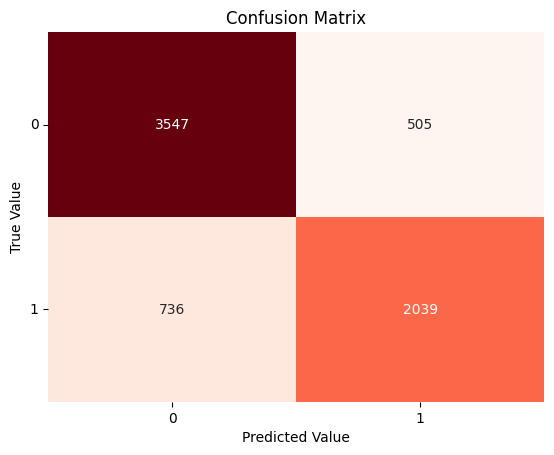

In [ ]:
from sklearn.metrics import confusion_matrix
# Plot confusion matrix
conf_matrix = confusion_matrix(y_train, np.round(oof_preds).astype(int))

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)
plt.show()

Kết quả cho thấy mô hình dự đoán chính xác trên nhãn 0 cao hơn nhãn 1. Nguyên nhân một phần vì chưa xử lý mất công bằng dữ liệu đầu vào trên các nhãn.

In [ ]:
# submission = pd.DataFrame({"id": df_test["id"],"target": test_pred})
# submission.to_csv('submission_OOF.csv', index=False)
# submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [ ]:
# files.download('submission_OOF.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Score: 0.84186